In [12]:
"""
@author: Maziar Raissi
"""

import sys
sys.path.insert(0, '../../Utilities/')

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [13]:
np.random.seed(1234)
tf.set_random_seed(1234)

In [14]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub):
        
        X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
        X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
        X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
        
        self.lb = lb
        self.ub = ub
               
        self.x0 = X0[:,0:1]
        self.t0 = X0[:,1:2]

        self.x_lb = X_lb[:,0:1]
        self.t_lb = X_lb[:,1:2]

        self.x_ub = X_ub[:,0:1]
        self.t_ub = X_ub[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u0 = u0
        self.v0 = v0
        
        # Initialize NNs
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf Placeholders        
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v0_tf = tf.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        
        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb.shape[1]])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb.shape[1]])
        
        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub.shape[1]])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])

        # tf Graphs
        self.u0_pred, self.v0_pred, _ , _ = self.net_uv(self.x0_tf, self.t0_tf)
        self.u_lb_pred, self.v_lb_pred, self.u_x_lb_pred, self.v_x_lb_pred = self.net_uv(self.x_lb_tf, self.t_lb_tf)
        self.u_ub_pred, self.v_ub_pred, self.u_x_ub_pred, self.v_x_ub_pred = self.net_uv(self.x_ub_tf, self.t_ub_tf)
        self.f_u_pred, self.f_v_pred = self.net_f_uv(self.x_f_tf, self.t_f_tf)
        
        # Loss
        self.loss = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \
                    tf.reduce_mean(tf.square(self.v0_tf - self.v0_pred)) + \
                    tf.reduce_mean(tf.square(self.u_lb_pred - self.u_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.v_lb_pred - self.v_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.u_x_lb_pred - self.u_x_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.v_x_lb_pred - self.v_x_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_v_pred))
        
        # Optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
              
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_uv(self, x, t):
        X = tf.concat([x,t],1)
        
        uv = self.neural_net(X, self.weights, self.biases)
        u = uv[:,0:1]
        v = uv[:,1:2]
        
        u_x = tf.gradients(u, x)[0]
        v_x = tf.gradients(v, x)[0]

        return u, v, u_x, v_x

    def net_f_uv(self, x, t):
        u, v, u_x, v_x = self.net_uv(x,t)
        
        u_t = tf.gradients(u, t)[0]
        u_xx = tf.gradients(u_x, x)[0]
        
        v_t = tf.gradients(v, t)[0]
        v_xx = tf.gradients(v_x, x)[0]
        
        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u   
        
        return f_u, f_v
    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self, nIter):
        
        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,
                   self.u0_tf: self.u0, self.v0_tf: self.v0,
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
                                                                                                                          
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
    def predict(self, X_star):
        
        tf_dict = {self.x0_tf: X_star[:,0:1], self.t0_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u0_pred, tf_dict)  
        v_star = self.sess.run(self.v0_pred, tf_dict)  
        
        
        tf_dict = {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]}
        
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
        f_v_star = self.sess.run(self.f_v_pred, tf_dict)
               
        return u_star, v_star, f_u_star, f_v_star


In [17]:
noise = 0.0        
    
# Doman bounds
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])

N0 = 50
N_b = 50
N_f = 20000
layers = [2, 100, 100, 100, 100, 2]

data = scipy.io.loadmat('main/Data/NLS.mat')

t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.T.flatten()[:,None]
v_star = Exact_v.T.flatten()[:,None]
h_star = Exact_h.T.flatten()[:,None]

In [19]:
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x,:]
u0 = Exact_u[idx_x,0:1]
v0 = Exact_v[idx_x,0:1]

idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]

X_f = lb + (ub-lb)*lhs(2, N_f)

model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub)
    
start_time = time.time()                
model.train(50000)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))


u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star)
h_pred = np.sqrt(u_pred**2 + v_pred**2)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
error_h = np.linalg.norm(h_star-h_pred,2)/np.linalg.norm(h_star,2)
print('Error u: %e' % (error_u))
print('Error v: %e' % (error_v))
print('Error h: %e' % (error_h))


U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')

FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')
FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')  

It: 0, Loss: 7.274e-01, Time: 0.59
It: 10, Loss: 5.386e-01, Time: 2.14
It: 20, Loss: 4.618e-01, Time: 2.01
It: 30, Loss: 4.528e-01, Time: 2.00
It: 40, Loss: 4.411e-01, Time: 2.08
It: 50, Loss: 4.317e-01, Time: 1.99
It: 60, Loss: 4.104e-01, Time: 2.02
It: 70, Loss: 3.751e-01, Time: 2.00
It: 80, Loss: 3.260e-01, Time: 2.08
It: 90, Loss: 2.706e-01, Time: 2.15
It: 100, Loss: 2.063e-01, Time: 2.35
It: 110, Loss: 1.701e-01, Time: 2.05
It: 120, Loss: 1.555e-01, Time: 2.05
It: 130, Loss: 1.469e-01, Time: 2.02
It: 140, Loss: 1.372e-01, Time: 1.99
It: 150, Loss: 1.284e-01, Time: 2.03
It: 160, Loss: 1.186e-01, Time: 2.05
It: 170, Loss: 1.094e-01, Time: 2.09
It: 180, Loss: 1.011e-01, Time: 2.02
It: 190, Loss: 9.421e-02, Time: 2.06
It: 200, Loss: 9.402e-02, Time: 2.02
It: 210, Loss: 8.539e-02, Time: 2.01
It: 220, Loss: 8.254e-02, Time: 2.02
It: 230, Loss: 7.939e-02, Time: 2.07
It: 240, Loss: 7.753e-02, Time: 2.19
It: 250, Loss: 7.568e-02, Time: 2.19
It: 260, Loss: 7.385e-02, Time: 2.10
It: 270, Los

It: 2190, Loss: 1.516e-02, Time: 2.01
It: 2200, Loss: 2.031e-02, Time: 2.06
It: 2210, Loss: 2.252e-02, Time: 2.03
It: 2220, Loss: 1.565e-02, Time: 2.03
It: 2230, Loss: 1.491e-02, Time: 2.11
It: 2240, Loss: 1.464e-02, Time: 2.13
It: 2250, Loss: 1.460e-02, Time: 2.07
It: 2260, Loss: 1.450e-02, Time: 2.04
It: 2270, Loss: 1.431e-02, Time: 2.01
It: 2280, Loss: 1.422e-02, Time: 2.06
It: 2290, Loss: 1.440e-02, Time: 2.03
It: 2300, Loss: 6.108e-02, Time: 2.00
It: 2310, Loss: 1.913e-02, Time: 2.04
It: 2320, Loss: 1.710e-02, Time: 2.03
It: 2330, Loss: 1.568e-02, Time: 2.02
It: 2340, Loss: 1.450e-02, Time: 1.99
It: 2350, Loss: 1.398e-02, Time: 2.04
It: 2360, Loss: 1.373e-02, Time: 2.05
It: 2370, Loss: 1.354e-02, Time: 2.04
It: 2380, Loss: 1.343e-02, Time: 2.07
It: 2390, Loss: 1.334e-02, Time: 2.06
It: 2400, Loss: 1.324e-02, Time: 2.03
It: 2410, Loss: 1.315e-02, Time: 2.11
It: 2420, Loss: 1.466e-02, Time: 2.07
It: 2430, Loss: 1.443e-02, Time: 2.12
It: 2440, Loss: 1.744e-02, Time: 2.12
It: 2450, Lo

It: 4350, Loss: 6.089e-03, Time: 2.22
It: 4360, Loss: 5.448e-03, Time: 2.20
It: 4370, Loss: 5.351e-03, Time: 2.15
It: 4380, Loss: 5.271e-03, Time: 2.12
It: 4390, Loss: 5.234e-03, Time: 2.14
It: 4400, Loss: 5.196e-03, Time: 2.13
It: 4410, Loss: 5.166e-03, Time: 2.12
It: 4420, Loss: 5.146e-03, Time: 2.18
It: 4430, Loss: 7.012e-03, Time: 2.32
It: 4440, Loss: 2.103e-02, Time: 2.13
It: 4450, Loss: 1.658e-02, Time: 2.16
It: 4460, Loss: 8.323e-03, Time: 2.08
It: 4470, Loss: 5.949e-03, Time: 2.09
It: 4480, Loss: 5.328e-03, Time: 2.10
It: 4490, Loss: 5.164e-03, Time: 2.18
It: 4500, Loss: 5.083e-03, Time: 2.18
It: 4510, Loss: 5.014e-03, Time: 2.10
It: 4520, Loss: 4.962e-03, Time: 2.09
It: 4530, Loss: 4.932e-03, Time: 2.09
It: 4540, Loss: 4.900e-03, Time: 2.10
It: 4550, Loss: 4.870e-03, Time: 2.14
It: 4560, Loss: 4.840e-03, Time: 2.26
It: 4570, Loss: 4.810e-03, Time: 2.27
It: 4580, Loss: 4.782e-03, Time: 2.13
It: 4590, Loss: 5.091e-03, Time: 2.10
It: 4600, Loss: 4.766e-02, Time: 2.12
It: 4610, Lo

It: 6510, Loss: 3.390e-02, Time: 2.19
It: 6520, Loss: 1.122e-02, Time: 2.20
It: 6530, Loss: 6.228e-03, Time: 2.10
It: 6540, Loss: 3.633e-03, Time: 2.19
It: 6550, Loss: 2.723e-03, Time: 2.15
It: 6560, Loss: 2.261e-03, Time: 2.06
It: 6570, Loss: 2.147e-03, Time: 2.04
It: 6580, Loss: 2.135e-03, Time: 2.06
It: 6590, Loss: 2.109e-03, Time: 2.24
It: 6600, Loss: 2.093e-03, Time: 2.18
It: 6610, Loss: 2.079e-03, Time: 2.15
It: 6620, Loss: 2.067e-03, Time: 2.15
It: 6630, Loss: 2.055e-03, Time: 2.03
It: 6640, Loss: 2.043e-03, Time: 2.06
It: 6650, Loss: 2.031e-03, Time: 2.02
It: 6660, Loss: 2.020e-03, Time: 2.06
It: 6670, Loss: 2.011e-03, Time: 2.10
It: 6680, Loss: 2.334e-03, Time: 2.05
It: 6690, Loss: 5.234e-02, Time: 2.04
It: 6700, Loss: 5.184e-03, Time: 2.12
It: 6710, Loss: 5.102e-03, Time: 2.22
It: 6720, Loss: 3.950e-03, Time: 2.21
It: 6730, Loss: 2.411e-03, Time: 2.12
It: 6740, Loss: 2.030e-03, Time: 2.19
It: 6750, Loss: 2.003e-03, Time: 2.05
It: 6760, Loss: 1.993e-03, Time: 2.09
It: 6770, Lo

It: 8670, Loss: 3.615e-03, Time: 2.21
It: 8680, Loss: 1.498e-03, Time: 2.28
It: 8690, Loss: 1.309e-03, Time: 2.14
It: 8700, Loss: 1.201e-03, Time: 2.22
It: 8710, Loss: 1.170e-03, Time: 2.40
It: 8720, Loss: 1.125e-03, Time: 2.25
It: 8730, Loss: 1.099e-03, Time: 2.31
It: 8740, Loss: 1.078e-03, Time: 2.27
It: 8750, Loss: 1.067e-03, Time: 2.36
It: 8760, Loss: 1.060e-03, Time: 2.41
It: 8770, Loss: 1.053e-03, Time: 2.20
It: 8780, Loss: 1.047e-03, Time: 2.20
It: 8790, Loss: 1.041e-03, Time: 2.18
It: 8800, Loss: 1.035e-03, Time: 2.21
It: 8810, Loss: 1.029e-03, Time: 2.27
It: 8820, Loss: 1.024e-03, Time: 2.24
It: 8830, Loss: 1.018e-03, Time: 2.22
It: 8840, Loss: 1.013e-03, Time: 2.22
It: 8850, Loss: 1.027e-03, Time: 2.34
It: 8860, Loss: 5.661e-03, Time: 2.26
It: 8870, Loss: 3.601e-02, Time: 2.25
It: 8880, Loss: 3.493e-03, Time: 2.34
It: 8890, Loss: 3.214e-03, Time: 2.29
It: 8900, Loss: 1.864e-03, Time: 2.38
It: 8910, Loss: 1.337e-03, Time: 2.41
It: 8920, Loss: 1.158e-03, Time: 2.28
It: 8930, Lo

It: 10810, Loss: 3.044e-02, Time: 2.36
It: 10820, Loss: 3.393e-03, Time: 2.51
It: 10830, Loss: 1.769e-03, Time: 2.12
It: 10840, Loss: 1.431e-03, Time: 2.18
It: 10850, Loss: 9.516e-04, Time: 2.08
It: 10860, Loss: 7.715e-04, Time: 2.22
It: 10870, Loss: 6.676e-04, Time: 2.06
It: 10880, Loss: 6.412e-04, Time: 2.13
It: 10890, Loss: 6.425e-04, Time: 2.12
It: 10900, Loss: 8.427e-04, Time: 2.08
It: 10910, Loss: 1.690e-02, Time: 2.11
It: 10920, Loss: 1.061e-02, Time: 2.10
It: 10930, Loss: 1.930e-03, Time: 2.25
It: 10940, Loss: 1.273e-03, Time: 2.04
It: 10950, Loss: 1.062e-03, Time: 2.12
It: 10960, Loss: 7.159e-04, Time: 2.12
It: 10970, Loss: 6.626e-04, Time: 2.03
It: 10980, Loss: 6.538e-04, Time: 2.10
It: 10990, Loss: 6.297e-04, Time: 2.01
It: 11000, Loss: 6.221e-04, Time: 2.08
It: 11010, Loss: 6.173e-04, Time: 2.21
It: 11020, Loss: 6.143e-04, Time: 2.61
It: 11030, Loss: 6.133e-04, Time: 2.30
It: 11040, Loss: 7.161e-04, Time: 2.60
It: 11050, Loss: 8.776e-03, Time: 2.35
It: 11060, Loss: 8.508e-0

It: 12920, Loss: 4.616e-04, Time: 2.58
It: 12930, Loss: 6.248e-04, Time: 2.21
It: 12940, Loss: 9.936e-03, Time: 2.20
It: 12950, Loss: 5.174e-03, Time: 2.19
It: 12960, Loss: 2.060e-03, Time: 2.32
It: 12970, Loss: 1.230e-03, Time: 2.39
It: 12980, Loss: 6.359e-04, Time: 2.11
It: 12990, Loss: 5.309e-04, Time: 2.08
It: 13000, Loss: 4.937e-04, Time: 2.39
It: 13010, Loss: 4.626e-04, Time: 2.12
It: 13020, Loss: 4.533e-04, Time: 2.18
It: 13030, Loss: 4.583e-04, Time: 2.15
It: 13040, Loss: 1.024e-03, Time: 2.10
It: 13050, Loss: 2.192e-02, Time: 2.41
It: 13060, Loss: 2.588e-03, Time: 2.32
It: 13070, Loss: 1.367e-03, Time: 2.22
It: 13080, Loss: 8.717e-04, Time: 2.14
It: 13090, Loss: 6.944e-04, Time: 2.17
It: 13100, Loss: 4.793e-04, Time: 2.12
It: 13110, Loss: 4.696e-04, Time: 3.04
It: 13120, Loss: 4.491e-04, Time: 3.02
It: 13130, Loss: 4.444e-04, Time: 2.79
It: 13140, Loss: 4.393e-04, Time: 2.70
It: 13150, Loss: 4.418e-04, Time: 2.82
It: 13160, Loss: 6.362e-04, Time: 2.73
It: 13170, Loss: 9.180e-0

It: 15030, Loss: 4.737e-03, Time: 2.17
It: 15040, Loss: 1.842e-03, Time: 2.11
It: 15050, Loss: 7.962e-04, Time: 2.20
It: 15060, Loss: 5.587e-04, Time: 2.15
It: 15070, Loss: 4.635e-04, Time: 2.46
It: 15080, Loss: 3.895e-04, Time: 2.39
It: 15090, Loss: 3.623e-04, Time: 2.31
It: 15100, Loss: 4.097e-04, Time: 3.48
It: 15110, Loss: 4.589e-03, Time: 2.73
It: 15120, Loss: 1.463e-03, Time: 2.21
It: 15130, Loss: 3.225e-03, Time: 2.18
It: 15140, Loss: 1.492e-03, Time: 2.21
It: 15150, Loss: 6.132e-04, Time: 2.17
It: 15160, Loss: 3.653e-04, Time: 2.31
It: 15170, Loss: 3.929e-04, Time: 2.21
It: 15180, Loss: 3.719e-04, Time: 2.16
It: 15190, Loss: 3.508e-04, Time: 2.09
It: 15200, Loss: 3.536e-04, Time: 2.20
It: 15210, Loss: 4.859e-04, Time: 2.25
It: 15220, Loss: 1.301e-02, Time: 2.17
It: 15230, Loss: 8.873e-03, Time: 2.17
It: 15240, Loss: 2.342e-03, Time: 2.19
It: 15250, Loss: 9.241e-04, Time: 2.24
It: 15260, Loss: 4.470e-04, Time: 2.28
It: 15270, Loss: 4.290e-04, Time: 2.28
It: 15280, Loss: 3.930e-0

It: 17140, Loss: 5.086e-04, Time: 2.16
It: 17150, Loss: 9.262e-03, Time: 2.31
It: 17160, Loss: 4.148e-03, Time: 2.14
It: 17170, Loss: 1.805e-03, Time: 2.11
It: 17180, Loss: 8.964e-04, Time: 2.13
It: 17190, Loss: 3.627e-04, Time: 2.12
It: 17200, Loss: 4.154e-04, Time: 2.12
It: 17210, Loss: 3.146e-04, Time: 2.11
It: 17220, Loss: 3.135e-04, Time: 2.11
It: 17230, Loss: 4.363e-04, Time: 2.04
It: 17240, Loss: 1.018e-02, Time: 2.01
It: 17250, Loss: 6.999e-03, Time: 2.07
It: 17260, Loss: 9.332e-04, Time: 2.11
It: 17270, Loss: 8.851e-04, Time: 2.04
It: 17280, Loss: 5.563e-04, Time: 2.03
It: 17290, Loss: 3.787e-04, Time: 2.06
It: 17300, Loss: 3.246e-04, Time: 2.03
It: 17310, Loss: 3.065e-04, Time: 2.07
It: 17320, Loss: 2.990e-04, Time: 2.12
It: 17330, Loss: 2.957e-04, Time: 2.15
It: 17340, Loss: 3.020e-04, Time: 2.12
It: 17350, Loss: 7.997e-04, Time: 2.07
It: 17360, Loss: 2.077e-02, Time: 2.08
It: 17370, Loss: 2.775e-03, Time: 2.12
It: 17380, Loss: 2.600e-03, Time: 2.09
It: 17390, Loss: 9.974e-0

It: 19250, Loss: 1.125e-03, Time: 2.03
It: 19260, Loss: 3.260e-04, Time: 2.37
It: 19270, Loss: 2.934e-04, Time: 1.99
It: 19280, Loss: 3.691e-04, Time: 2.06
It: 19290, Loss: 2.171e-03, Time: 2.05
It: 19300, Loss: 7.234e-03, Time: 2.09
It: 19310, Loss: 6.663e-04, Time: 2.02
It: 19320, Loss: 1.134e-03, Time: 2.15
It: 19330, Loss: 6.493e-04, Time: 2.20
It: 19340, Loss: 3.461e-04, Time: 2.06
It: 19350, Loss: 2.867e-04, Time: 2.09
It: 19360, Loss: 3.044e-04, Time: 2.06
It: 19370, Loss: 1.351e-03, Time: 2.02
It: 19380, Loss: 1.018e-02, Time: 2.08
It: 19390, Loss: 1.718e-03, Time: 2.05
It: 19400, Loss: 9.052e-04, Time: 2.04
It: 19410, Loss: 6.207e-04, Time: 2.15
It: 19420, Loss: 8.558e-04, Time: 2.10
It: 19430, Loss: 3.705e-04, Time: 2.33
It: 19440, Loss: 3.054e-04, Time: 2.33
It: 19450, Loss: 3.478e-04, Time: 2.11
It: 19460, Loss: 1.046e-03, Time: 2.25
It: 19470, Loss: 5.008e-03, Time: 2.08
It: 19480, Loss: 1.789e-03, Time: 2.12
It: 19490, Loss: 3.189e-03, Time: 2.10
It: 19500, Loss: 2.683e-0

It: 21360, Loss: 2.218e-04, Time: 2.11
It: 21370, Loss: 2.259e-04, Time: 2.01
It: 21380, Loss: 3.797e-04, Time: 2.13
It: 21390, Loss: 6.863e-03, Time: 2.00
It: 21400, Loss: 3.464e-03, Time: 2.10
It: 21410, Loss: 1.191e-03, Time: 2.29
It: 21420, Loss: 7.749e-04, Time: 2.04
It: 21430, Loss: 5.009e-04, Time: 2.03
It: 21440, Loss: 4.498e-04, Time: 2.06
It: 21450, Loss: 2.150e-03, Time: 2.02
It: 21460, Loss: 5.313e-03, Time: 2.06
It: 21470, Loss: 2.118e-03, Time: 2.04
It: 21480, Loss: 9.273e-04, Time: 2.05
It: 21490, Loss: 5.054e-04, Time: 2.00
It: 21500, Loss: 2.966e-04, Time: 2.02
It: 21510, Loss: 2.747e-04, Time: 2.01
It: 21520, Loss: 1.537e-03, Time: 2.01
It: 21530, Loss: 6.334e-03, Time: 1.99
It: 21540, Loss: 8.689e-04, Time: 2.05
It: 21550, Loss: 4.855e-04, Time: 2.31
It: 21560, Loss: 5.043e-04, Time: 2.07
It: 21570, Loss: 3.223e-04, Time: 2.06
It: 21580, Loss: 4.922e-04, Time: 2.03
It: 21590, Loss: 6.134e-03, Time: 2.06
It: 21600, Loss: 1.001e-03, Time: 2.14
It: 21610, Loss: 1.614e-0

It: 23470, Loss: 1.532e-03, Time: 2.32
It: 23480, Loss: 7.052e-03, Time: 2.24
It: 23490, Loss: 1.541e-03, Time: 2.23
It: 23500, Loss: 3.409e-04, Time: 2.24
It: 23510, Loss: 3.472e-04, Time: 2.26
It: 23520, Loss: 2.779e-04, Time: 2.11
It: 23530, Loss: 2.246e-04, Time: 2.11
It: 23540, Loss: 2.086e-04, Time: 2.14
It: 23550, Loss: 2.098e-04, Time: 2.09
It: 23560, Loss: 9.169e-04, Time: 2.07
It: 23570, Loss: 1.258e-02, Time: 2.20
It: 23580, Loss: 2.036e-03, Time: 2.22
It: 23590, Loss: 8.900e-04, Time: 2.22
It: 23600, Loss: 5.777e-04, Time: 2.23
It: 23610, Loss: 3.755e-04, Time: 2.21
It: 23620, Loss: 2.505e-04, Time: 2.23
It: 23630, Loss: 1.969e-04, Time: 2.13
It: 23640, Loss: 2.250e-04, Time: 2.08
It: 23650, Loss: 8.402e-04, Time: 2.12
It: 23660, Loss: 6.112e-03, Time: 2.18
It: 23670, Loss: 1.272e-02, Time: 2.12
It: 23680, Loss: 4.020e-03, Time: 2.02
It: 23690, Loss: 5.485e-04, Time: 2.04
It: 23700, Loss: 4.178e-04, Time: 2.12
It: 23710, Loss: 3.960e-04, Time: 2.03
It: 23720, Loss: 2.320e-0

It: 25580, Loss: 1.854e-04, Time: 2.17
It: 25590, Loss: 1.789e-04, Time: 2.20
It: 25600, Loss: 1.911e-04, Time: 2.16
It: 25610, Loss: 2.973e-03, Time: 2.16
It: 25620, Loss: 1.799e-03, Time: 2.13
It: 25630, Loss: 1.257e-03, Time: 2.16
It: 25640, Loss: 4.861e-04, Time: 2.07
It: 25650, Loss: 2.097e-04, Time: 2.21
It: 25660, Loss: 2.158e-04, Time: 2.17
It: 25670, Loss: 1.929e-04, Time: 2.08
It: 25680, Loss: 1.785e-04, Time: 2.08
It: 25690, Loss: 1.784e-04, Time: 2.27
It: 25700, Loss: 1.758e-04, Time: 2.19
It: 25710, Loss: 1.732e-04, Time: 2.10
It: 25720, Loss: 2.030e-04, Time: 2.09
It: 25730, Loss: 4.441e-03, Time: 2.15
It: 25740, Loss: 3.265e-03, Time: 2.10
It: 25750, Loss: 7.682e-04, Time: 2.06
It: 25760, Loss: 7.464e-04, Time: 2.17
It: 25770, Loss: 6.291e-04, Time: 2.14
It: 25780, Loss: 2.130e-04, Time: 2.07
It: 25790, Loss: 2.086e-04, Time: 2.35
It: 25800, Loss: 1.864e-04, Time: 2.30
It: 25810, Loss: 2.040e-04, Time: 2.45
It: 25820, Loss: 1.643e-03, Time: 2.37
It: 25830, Loss: 2.685e-0

It: 27690, Loss: 1.822e-04, Time: 2.24
It: 27700, Loss: 2.931e-04, Time: 2.24
It: 27710, Loss: 3.576e-03, Time: 2.29
It: 27720, Loss: 2.849e-04, Time: 2.25
It: 27730, Loss: 6.501e-04, Time: 2.16
It: 27740, Loss: 4.753e-04, Time: 2.19
It: 27750, Loss: 2.608e-04, Time: 2.29
It: 27760, Loss: 1.827e-04, Time: 2.20
It: 27770, Loss: 1.606e-04, Time: 2.21
It: 27780, Loss: 2.265e-04, Time: 2.21
It: 27790, Loss: 5.480e-03, Time: 2.29
It: 27800, Loss: 3.464e-03, Time: 2.33
It: 27810, Loss: 5.981e-04, Time: 2.43
It: 27820, Loss: 9.299e-04, Time: 2.33
It: 27830, Loss: 2.700e-04, Time: 2.17
It: 27840, Loss: 2.176e-04, Time: 2.09
It: 27850, Loss: 1.813e-04, Time: 2.09
It: 27860, Loss: 1.599e-04, Time: 2.25
It: 27870, Loss: 1.597e-04, Time: 2.29
It: 27880, Loss: 3.230e-04, Time: 2.14
It: 27890, Loss: 1.339e-02, Time: 2.10
It: 27900, Loss: 7.165e-03, Time: 2.08
It: 27910, Loss: 1.355e-03, Time: 2.11
It: 27920, Loss: 1.843e-04, Time: 2.14
It: 27930, Loss: 3.615e-04, Time: 2.36
It: 27940, Loss: 2.551e-0

It: 29800, Loss: 1.740e-04, Time: 2.14
It: 29810, Loss: 5.823e-04, Time: 2.09
It: 29820, Loss: 9.271e-03, Time: 2.12
It: 29830, Loss: 3.005e-03, Time: 2.09
It: 29840, Loss: 6.629e-04, Time: 2.15
It: 29850, Loss: 2.138e-04, Time: 2.14
It: 29860, Loss: 1.977e-04, Time: 2.11
It: 29870, Loss: 1.603e-04, Time: 2.10
It: 29880, Loss: 1.519e-04, Time: 2.03
It: 29890, Loss: 3.013e-04, Time: 2.04
It: 29900, Loss: 5.807e-03, Time: 2.22
It: 29910, Loss: 2.201e-03, Time: 2.30
It: 29920, Loss: 1.056e-03, Time: 2.33
It: 29930, Loss: 3.863e-04, Time: 2.22
It: 29940, Loss: 2.836e-04, Time: 2.19
It: 29950, Loss: 1.527e-04, Time: 2.27
It: 29960, Loss: 2.053e-04, Time: 2.15
It: 29970, Loss: 1.977e-03, Time: 2.15
It: 29980, Loss: 3.530e-03, Time: 2.13
It: 29990, Loss: 4.570e-04, Time: 2.11
It: 30000, Loss: 6.944e-04, Time: 2.14
It: 30010, Loss: 3.972e-04, Time: 2.14
It: 30020, Loss: 2.263e-04, Time: 2.17
It: 30030, Loss: 1.707e-04, Time: 2.21
It: 30040, Loss: 1.534e-04, Time: 2.26
It: 30050, Loss: 3.561e-0

It: 31910, Loss: 1.535e-04, Time: 2.18
It: 31920, Loss: 1.341e-04, Time: 2.24
It: 31930, Loss: 1.421e-04, Time: 2.13
It: 31940, Loss: 2.278e-04, Time: 2.19
It: 31950, Loss: 4.101e-03, Time: 2.07
It: 31960, Loss: 5.257e-04, Time: 2.31
It: 31970, Loss: 1.791e-03, Time: 2.30
It: 31980, Loss: 3.298e-04, Time: 2.27
It: 31990, Loss: 3.273e-04, Time: 2.14
It: 32000, Loss: 2.438e-04, Time: 2.19
It: 32010, Loss: 9.149e-04, Time: 2.22
It: 32020, Loss: 6.231e-03, Time: 2.24
It: 32030, Loss: 1.658e-03, Time: 2.30
It: 32040, Loss: 4.951e-04, Time: 2.20
It: 32050, Loss: 3.038e-04, Time: 2.18
It: 32060, Loss: 2.398e-04, Time: 2.45
It: 32070, Loss: 1.941e-04, Time: 2.12
It: 32080, Loss: 1.106e-03, Time: 2.07
It: 32090, Loss: 4.930e-03, Time: 2.13
It: 32100, Loss: 9.026e-04, Time: 2.29
It: 32110, Loss: 5.602e-04, Time: 2.33
It: 32120, Loss: 2.712e-04, Time: 2.24
It: 32130, Loss: 2.212e-04, Time: 2.37
It: 32140, Loss: 3.281e-04, Time: 2.25
It: 32150, Loss: 2.565e-03, Time: 2.27
It: 32160, Loss: 6.945e-0

It: 34020, Loss: 5.162e-04, Time: 2.03
It: 34030, Loss: 1.648e-04, Time: 2.03
It: 34040, Loss: 1.809e-04, Time: 2.02
It: 34050, Loss: 1.296e-04, Time: 2.00
It: 34060, Loss: 1.438e-04, Time: 2.01
It: 34070, Loss: 1.418e-03, Time: 2.28
It: 34080, Loss: 6.235e-03, Time: 2.26
It: 34090, Loss: 1.793e-03, Time: 2.21
It: 34100, Loss: 5.179e-04, Time: 2.17
It: 34110, Loss: 4.638e-04, Time: 2.24
It: 34120, Loss: 1.837e-04, Time: 2.28
It: 34130, Loss: 1.715e-04, Time: 2.19
It: 34140, Loss: 1.466e-04, Time: 2.13
It: 34150, Loss: 1.521e-04, Time: 2.03
It: 34160, Loss: 9.099e-04, Time: 2.00
It: 34170, Loss: 6.957e-03, Time: 2.03
It: 34180, Loss: 1.037e-03, Time: 2.05
It: 34190, Loss: 7.672e-04, Time: 2.13
It: 34200, Loss: 2.695e-04, Time: 2.04
It: 34210, Loss: 1.616e-04, Time: 2.50
It: 34220, Loss: 1.800e-04, Time: 2.13
It: 34230, Loss: 4.984e-04, Time: 2.07
It: 34240, Loss: 1.042e-03, Time: 2.06
It: 34250, Loss: 2.805e-04, Time: 2.05
It: 34260, Loss: 3.339e-04, Time: 2.00
It: 34270, Loss: 3.781e-0

It: 36130, Loss: 1.794e-04, Time: 2.29
It: 36140, Loss: 2.303e-04, Time: 2.30
It: 36150, Loss: 1.575e-03, Time: 2.26
It: 36160, Loss: 2.715e-03, Time: 2.20
It: 36170, Loss: 1.170e-03, Time: 2.20
It: 36180, Loss: 1.016e-03, Time: 2.23
It: 36190, Loss: 9.634e-04, Time: 2.19
It: 36200, Loss: 5.946e-04, Time: 2.58
It: 36210, Loss: 3.400e-04, Time: 2.30
It: 36220, Loss: 1.063e-03, Time: 2.16
It: 36230, Loss: 3.733e-03, Time: 2.26
It: 36240, Loss: 1.166e-03, Time: 2.47
It: 36250, Loss: 4.738e-04, Time: 2.35
It: 36260, Loss: 2.568e-04, Time: 2.45
It: 36270, Loss: 2.328e-04, Time: 2.50
It: 36280, Loss: 2.188e-03, Time: 2.27
It: 36290, Loss: 1.349e-03, Time: 2.28
It: 36300, Loss: 6.631e-04, Time: 2.16
It: 36310, Loss: 7.599e-04, Time: 2.24
It: 36320, Loss: 8.456e-04, Time: 2.24
It: 36330, Loss: 2.502e-03, Time: 2.27
It: 36340, Loss: 3.881e-04, Time: 2.37
It: 36350, Loss: 5.974e-04, Time: 2.30
It: 36360, Loss: 2.311e-04, Time: 2.21
It: 36370, Loss: 2.359e-04, Time: 2.23
It: 36380, Loss: 9.421e-0

It: 38240, Loss: 2.576e-03, Time: 2.28
It: 38250, Loss: 1.152e-03, Time: 2.41
It: 38260, Loss: 1.470e-04, Time: 2.34
It: 38270, Loss: 2.778e-04, Time: 2.23
It: 38280, Loss: 7.860e-04, Time: 2.29
It: 38290, Loss: 2.183e-03, Time: 2.68
It: 38300, Loss: 2.404e-03, Time: 2.68
It: 38310, Loss: 2.288e-03, Time: 2.45
It: 38320, Loss: 4.162e-04, Time: 2.42
It: 38330, Loss: 3.955e-04, Time: 2.25
It: 38340, Loss: 2.161e-04, Time: 2.25
It: 38350, Loss: 1.441e-04, Time: 2.28
It: 38360, Loss: 1.821e-04, Time: 2.26
It: 38370, Loss: 2.161e-03, Time: 2.31
It: 38380, Loss: 1.678e-03, Time: 2.42
It: 38390, Loss: 5.163e-04, Time: 2.74
It: 38400, Loss: 8.149e-04, Time: 2.33
It: 38410, Loss: 1.506e-04, Time: 2.25
It: 38420, Loss: 1.374e-04, Time: 2.16
It: 38430, Loss: 2.352e-04, Time: 2.16
It: 38440, Loss: 3.749e-03, Time: 2.17
It: 38450, Loss: 3.821e-04, Time: 2.29
It: 38460, Loss: 1.603e-03, Time: 2.17
It: 38470, Loss: 4.943e-04, Time: 2.18
It: 38480, Loss: 1.441e-04, Time: 2.20
It: 38490, Loss: 1.819e-0

It: 40350, Loss: 7.768e-04, Time: 2.18
It: 40360, Loss: 1.126e-03, Time: 2.11
It: 40370, Loss: 6.263e-04, Time: 2.12
It: 40380, Loss: 4.673e-04, Time: 2.09
It: 40390, Loss: 4.802e-04, Time: 2.05
It: 40400, Loss: 4.400e-03, Time: 2.16
It: 40410, Loss: 7.495e-04, Time: 2.08
It: 40420, Loss: 4.577e-04, Time: 2.08
It: 40430, Loss: 3.283e-04, Time: 2.08
It: 40440, Loss: 3.059e-04, Time: 2.06
It: 40450, Loss: 2.852e-03, Time: 2.07
It: 40460, Loss: 3.104e-04, Time: 2.19
It: 40470, Loss: 4.470e-04, Time: 2.17
It: 40480, Loss: 3.629e-04, Time: 2.11
It: 40490, Loss: 2.328e-04, Time: 2.33
It: 40500, Loss: 6.580e-04, Time: 2.26
It: 40510, Loss: 4.822e-03, Time: 2.24
It: 40520, Loss: 1.177e-03, Time: 2.35
It: 40530, Loss: 3.523e-04, Time: 2.26
It: 40540, Loss: 3.296e-04, Time: 2.36
It: 40550, Loss: 4.802e-04, Time: 2.25
It: 40560, Loss: 3.346e-04, Time: 2.22
It: 40570, Loss: 3.349e-04, Time: 2.29
It: 40580, Loss: 1.808e-03, Time: 2.17
It: 40590, Loss: 2.317e-03, Time: 2.23
It: 40600, Loss: 9.577e-0

It: 42460, Loss: 9.720e-05, Time: 2.06
It: 42470, Loss: 1.055e-04, Time: 2.04
It: 42480, Loss: 6.566e-04, Time: 2.02
It: 42490, Loss: 1.091e-02, Time: 2.00
It: 42500, Loss: 3.112e-03, Time: 2.01
It: 42510, Loss: 7.600e-04, Time: 2.07
It: 42520, Loss: 4.539e-04, Time: 2.11
It: 42530, Loss: 2.677e-04, Time: 2.08
It: 42540, Loss: 1.771e-04, Time: 2.09
It: 42550, Loss: 1.234e-04, Time: 2.06
It: 42560, Loss: 1.066e-04, Time: 2.15
It: 42570, Loss: 1.063e-04, Time: 2.10
It: 42580, Loss: 2.408e-04, Time: 2.09
It: 42590, Loss: 5.390e-03, Time: 2.12
It: 42600, Loss: 2.014e-03, Time: 2.14
It: 42610, Loss: 1.031e-03, Time: 2.06
It: 42620, Loss: 3.424e-04, Time: 2.03
It: 42630, Loss: 1.751e-04, Time: 2.04
It: 42640, Loss: 1.433e-04, Time: 2.09
It: 42650, Loss: 1.107e-03, Time: 2.06
It: 42660, Loss: 3.689e-03, Time: 2.08
It: 42670, Loss: 1.125e-03, Time: 2.08
It: 42680, Loss: 3.570e-04, Time: 2.10
It: 42690, Loss: 2.198e-04, Time: 2.12
It: 42700, Loss: 4.804e-04, Time: 2.11
It: 42710, Loss: 2.792e-0

It: 44570, Loss: 1.939e-04, Time: 2.14
It: 44580, Loss: 6.320e-04, Time: 2.20
It: 44590, Loss: 4.242e-03, Time: 2.12
It: 44600, Loss: 2.383e-03, Time: 2.17
It: 44610, Loss: 6.487e-04, Time: 2.09
It: 44620, Loss: 4.741e-04, Time: 2.09
It: 44630, Loss: 2.331e-04, Time: 2.12
It: 44640, Loss: 1.225e-04, Time: 2.13
It: 44650, Loss: 9.330e-05, Time: 2.15
It: 44660, Loss: 1.406e-04, Time: 2.19
It: 44670, Loss: 1.633e-03, Time: 2.02
It: 44680, Loss: 5.256e-03, Time: 2.08
It: 44690, Loss: 2.294e-03, Time: 2.14
It: 44700, Loss: 1.424e-03, Time: 2.20
It: 44710, Loss: 4.938e-04, Time: 2.12
It: 44720, Loss: 2.771e-04, Time: 2.06
It: 44730, Loss: 1.287e-04, Time: 2.10
It: 44740, Loss: 1.309e-04, Time: 2.10
It: 44750, Loss: 2.514e-04, Time: 2.08
It: 44760, Loss: 1.743e-03, Time: 2.10
It: 44770, Loss: 1.440e-03, Time: 2.05
It: 44780, Loss: 8.007e-04, Time: 2.03
It: 44790, Loss: 4.669e-04, Time: 2.04
It: 44800, Loss: 2.714e-04, Time: 2.06
It: 44810, Loss: 6.258e-04, Time: 2.04
It: 44820, Loss: 5.130e-0

It: 46680, Loss: 1.225e-03, Time: 2.07
It: 46690, Loss: 2.556e-04, Time: 2.14
It: 46700, Loss: 2.858e-04, Time: 2.08
It: 46710, Loss: 1.602e-04, Time: 2.13
It: 46720, Loss: 1.341e-04, Time: 2.15
It: 46730, Loss: 3.206e-04, Time: 2.22
It: 46740, Loss: 4.155e-03, Time: 2.08
It: 46750, Loss: 8.293e-04, Time: 2.05
It: 46760, Loss: 6.131e-04, Time: 2.21
It: 46770, Loss: 2.851e-04, Time: 2.07
It: 46780, Loss: 5.862e-04, Time: 2.06
It: 46790, Loss: 3.875e-04, Time: 2.05
It: 46800, Loss: 2.323e-04, Time: 2.13
It: 46810, Loss: 1.800e-04, Time: 2.06
It: 46820, Loss: 4.249e-03, Time: 2.04
It: 46830, Loss: 2.673e-03, Time: 2.07
It: 46840, Loss: 5.207e-04, Time: 2.06
It: 46850, Loss: 7.894e-04, Time: 2.05
It: 46860, Loss: 3.380e-04, Time: 2.04
It: 46870, Loss: 1.021e-04, Time: 2.06
It: 46880, Loss: 1.143e-04, Time: 2.10
It: 46890, Loss: 9.565e-05, Time: 2.04
It: 46900, Loss: 9.086e-05, Time: 2.04
It: 46910, Loss: 8.741e-05, Time: 2.03
It: 46920, Loss: 1.023e-04, Time: 2.12
It: 46930, Loss: 1.170e-0

It: 48790, Loss: 2.925e-04, Time: 2.06
It: 48800, Loss: 1.224e-04, Time: 2.08
It: 48810, Loss: 1.974e-04, Time: 2.28
It: 48820, Loss: 1.173e-03, Time: 2.11
It: 48830, Loss: 1.961e-03, Time: 2.08
It: 48840, Loss: 7.176e-04, Time: 2.12
It: 48850, Loss: 2.021e-04, Time: 2.15
It: 48860, Loss: 1.864e-04, Time: 2.08
It: 48870, Loss: 3.020e-04, Time: 2.11
It: 48880, Loss: 7.372e-03, Time: 2.11
It: 48890, Loss: 2.526e-03, Time: 2.17
It: 48900, Loss: 2.891e-04, Time: 2.06
It: 48910, Loss: 2.975e-04, Time: 2.08
It: 48920, Loss: 1.577e-04, Time: 2.13
It: 48930, Loss: 1.150e-04, Time: 2.07
It: 48940, Loss: 9.024e-05, Time: 2.14
It: 48950, Loss: 1.990e-04, Time: 2.12
It: 48960, Loss: 5.397e-03, Time: 2.19
It: 48970, Loss: 2.846e-03, Time: 2.13
It: 48980, Loss: 9.150e-04, Time: 2.11
It: 48990, Loss: 2.780e-04, Time: 2.13
It: 49000, Loss: 2.195e-04, Time: 2.10
It: 49010, Loss: 1.127e-04, Time: 2.10
It: 49020, Loss: 1.045e-04, Time: 2.16
It: 49030, Loss: 5.346e-04, Time: 2.10
It: 49040, Loss: 8.775e-0

Loss: 6.368307e-05
Loss: 6.3580555e-05
Loss: 6.348401e-05
Loss: 6.33616e-05
Loss: 6.326339e-05
Loss: 6.316757e-05
Loss: 6.3089814e-05
Loss: 6.311606e-05
Loss: 6.3053674e-05
Loss: 6.301176e-05
Loss: 6.295224e-05
Loss: 6.289334e-05
Loss: 6.277596e-05
Loss: 6.293952e-05
Loss: 6.274243e-05
Loss: 6.264703e-05
Loss: 6.256795e-05
Loss: 6.247959e-05
Loss: 6.2400344e-05
Loss: 6.225589e-05
Loss: 6.3137806e-05
Loss: 6.223476e-05
Loss: 6.2145235e-05
Loss: 6.2089384e-05
Loss: 6.198262e-05
Loss: 6.1897175e-05
Loss: 6.1833736e-05
Loss: 6.1762075e-05
Loss: 6.1716346e-05
Loss: 6.153604e-05
Loss: 6.173425e-05
Loss: 6.14868e-05
Loss: 6.139823e-05
Loss: 6.1288265e-05
Loss: 6.116851e-05
Loss: 6.106295e-05
Loss: 6.0957376e-05
Loss: 6.0832976e-05
Loss: 6.0722905e-05
Loss: 6.0564475e-05
Loss: 6.0459875e-05
Loss: 6.0350605e-05
Loss: 6.0267997e-05
Loss: 6.017526e-05
Loss: 6.0049417e-05
Loss: 5.994032e-05
Loss: 5.9838876e-05
Loss: 5.9742553e-05
Loss: 5.9658534e-05
Loss: 5.9574733e-05
Loss: 5.9517664e-05
Loss: 5.

Loss: 3.5249745e-05
Loss: 3.521832e-05
Loss: 3.5170124e-05
Loss: 3.511727e-05
Loss: 3.5022935e-05
Loss: 3.4991914e-05
Loss: 3.4927187e-05
Loss: 3.489494e-05
Loss: 3.4876317e-05
Loss: 3.4853667e-05
Loss: 3.4774333e-05
Loss: 3.4718345e-05
Loss: 3.4688543e-05
Loss: 3.4639972e-05
Loss: 3.462526e-05
Loss: 3.458885e-05
Loss: 3.4537206e-05
Loss: 3.4451703e-05
Loss: 3.4533285e-05
Loss: 3.4414763e-05
Loss: 3.4335157e-05
Loss: 3.4272376e-05
Loss: 3.4209603e-05
Loss: 3.416883e-05
Loss: 3.409931e-05
Loss: 3.4052457e-05
Loss: 3.4010664e-05
Loss: 3.3966207e-05
Loss: 3.4032928e-05
Loss: 3.393964e-05
Loss: 3.3878725e-05
Loss: 3.3844095e-05
Loss: 3.378651e-05
Loss: 3.371944e-05
Loss: 3.3738503e-05
Loss: 3.3680033e-05
Loss: 3.3644472e-05
Loss: 3.3620112e-05
Loss: 3.359445e-05
Loss: 3.356381e-05
Loss: 3.3526754e-05
Loss: 3.3486118e-05
Loss: 3.3466335e-05
Loss: 3.342601e-05
Loss: 3.338232e-05
Loss: 3.3342923e-05
Loss: 3.328702e-05
Loss: 3.326437e-05
Loss: 3.320995e-05
Loss: 3.3143333e-05
Loss: 3.3052827e-

Loss: 2.1180884e-05
Loss: 2.1136346e-05
Loss: 2.1280364e-05
Loss: 2.112723e-05
Loss: 2.109978e-05
Loss: 2.107331e-05
Loss: 2.1036674e-05
Loss: 2.1002474e-05
Loss: 2.096843e-05
Loss: 2.0944299e-05
Loss: 2.0928856e-05
Loss: 2.091954e-05
Loss: 2.0906376e-05
Loss: 2.0892461e-05
Loss: 2.085431e-05
Loss: 2.0908294e-05
Loss: 2.0836738e-05
Loss: 2.0794381e-05
Loss: 2.0772706e-05
Loss: 2.0754753e-05
Loss: 2.0734646e-05
Loss: 2.0747288e-05
Loss: 2.0720145e-05
Loss: 2.0690062e-05
Loss: 2.0664811e-05
Loss: 2.0646225e-05
Loss: 2.0610474e-05
Loss: 2.0552994e-05
Loss: 2.0579606e-05
Loss: 2.0527605e-05
Loss: 2.0500524e-05
Loss: 2.0497238e-05
Loss: 2.047927e-05
Loss: 2.0473617e-05
Loss: 2.0456237e-05
Loss: 2.0438354e-05
Loss: 2.0392636e-05
Loss: 2.0446314e-05
Loss: 2.0374186e-05
Loss: 2.0354602e-05
Loss: 2.0340272e-05
Loss: 2.0322703e-05
Loss: 2.0286028e-05
Loss: 2.0285133e-05
Loss: 2.0263606e-05
Loss: 2.0238276e-05
Loss: 2.022607e-05
Loss: 2.0213436e-05
Loss: 2.0198484e-05
Loss: 2.0174422e-05
Loss: 2.

Loss: 1.4032151e-05
Loss: 1.40274715e-05
Loss: 1.4016427e-05
Loss: 1.4000414e-05
Loss: 1.3999928e-05
Loss: 1.3990658e-05
Loss: 1.3972416e-05
Loss: 1.3963094e-05
Loss: 1.3951407e-05
Loss: 1.3938683e-05
Loss: 1.3924846e-05
Loss: 1.3902232e-05
Loss: 1.3891371e-05
Loss: 1.3879185e-05
Loss: 1.3868081e-05
Loss: 1.385313e-05
Loss: 1.3842435e-05
Loss: 1.3834692e-05
Loss: 1.3823775e-05
Loss: 1.3811574e-05
Loss: 1.3789892e-05
Loss: 1.3774498e-05
Loss: 1.3758191e-05
Loss: 1.3744169e-05
Loss: 1.3737009e-05
Loss: 1.3724248e-05
Loss: 1.3711794e-05
Loss: 1.3698253e-05
Loss: 1.3674084e-05
Loss: 1.37152365e-05
Loss: 1.366345e-05
Loss: 1.3649879e-05
Loss: 1.36422605e-05
Loss: 1.3624593e-05
Loss: 1.3599107e-05
Loss: 1.3732071e-05
Loss: 1.3592728e-05
Loss: 1.3572917e-05
Loss: 1.3560108e-05
Loss: 1.3539366e-05
Loss: 1.3514646e-05
Loss: 1.348147e-05
Loss: 1.3482171e-05
Loss: 1.3467731e-05
Loss: 1.3455359e-05
Loss: 1.3447661e-05
Loss: 1.344751e-05
Loss: 1.3443176e-05
Loss: 1.3433805e-05
Loss: 1.3417679e-05
L

Loss: 9.88579e-06
Loss: 9.87377e-06
Loss: 9.864695e-06
Loss: 9.8561595e-06
Loss: 9.844107e-06
Loss: 9.832302e-06
Loss: 9.821541e-06
Loss: 9.812853e-06
Loss: 9.8021455e-06
Loss: 9.7940665e-06
Loss: 9.788753e-06
Loss: 9.7869615e-06
Loss: 9.782731e-06
Loss: 9.778569e-06
Loss: 9.772581e-06
Loss: 9.765639e-06
Loss: 9.752532e-06
Loss: 9.740925e-06
Loss: 9.727037e-06
Loss: 9.720781e-06
Loss: 9.709235e-06
Loss: 9.702251e-06
Loss: 9.695228e-06
Loss: 9.689025e-06
Loss: 9.684041e-06
Loss: 9.675832e-06
Loss: 9.670843e-06
Loss: 9.665186e-06
Loss: 9.6598615e-06
Loss: 9.654662e-06
Loss: 9.646479e-06
Loss: 9.6405165e-06
Loss: 9.632742e-06
Loss: 9.627233e-06
Loss: 9.620656e-06
Loss: 9.6153935e-06
Loss: 9.61056e-06
Loss: 9.604378e-06
Loss: 9.600912e-06
Loss: 9.595448e-06
Loss: 9.589103e-06
Loss: 9.577651e-06
Loss: 9.6439835e-06
Loss: 9.573622e-06
Loss: 9.565588e-06
Loss: 9.557176e-06
Loss: 9.547755e-06
Loss: 9.5411415e-06
Loss: 9.533506e-06
Loss: 9.52657e-06
Loss: 9.523521e-06
Loss: 9.514673e-06
Loss: 9

Loss: 7.199268e-06
Loss: 7.1962877e-06
Loss: 7.192376e-06
Loss: 7.1869404e-06
Loss: 7.176862e-06
Loss: 7.177442e-06
Loss: 7.1726176e-06
Loss: 7.168844e-06
Loss: 7.1614586e-06
Loss: 7.1568043e-06
Loss: 7.147104e-06
Loss: 7.1444947e-06
Loss: 7.135306e-06
Loss: 7.1316713e-06
Loss: 7.126553e-06
Loss: 7.116828e-06
Loss: 7.107372e-06
Loss: 7.112276e-06
Loss: 7.103594e-06
Loss: 7.0982173e-06
Loss: 7.089952e-06
Loss: 7.0816786e-06
Loss: 7.069462e-06
Loss: 7.089505e-06
Loss: 7.0651517e-06
Loss: 7.058883e-06
Loss: 7.05285e-06
Loss: 7.044162e-06
Loss: 7.032827e-06
Loss: 7.023208e-06
Loss: 7.014894e-06
Loss: 7.010224e-06
Loss: 7.0062333e-06
Loss: 7.041528e-06
Loss: 7.0043843e-06
Loss: 6.9983234e-06
Loss: 6.9907546e-06
Loss: 6.982119e-06
Loss: 6.973504e-06
Loss: 6.964971e-06
Loss: 6.9533444e-06
Loss: 6.9489715e-06
Loss: 6.945209e-06
Loss: 6.9419148e-06
Loss: 6.9380126e-06
Loss: 6.9283833e-06
Loss: 6.921563e-06
Loss: 6.9191983e-06
Loss: 6.9084326e-06
Loss: 6.9061184e-06
Loss: 6.8987847e-06
Loss: 6.8

Loss: 5.5002456e-06
Loss: 5.4961156e-06
Loss: 5.491116e-06
Loss: 5.4870497e-06
Loss: 5.483442e-06
Loss: 5.4780794e-06
Loss: 5.481953e-06
Loss: 5.4747898e-06
Loss: 5.470217e-06
Loss: 5.4668617e-06
Loss: 5.465061e-06
Loss: 5.457985e-06
Loss: 5.4558536e-06
Loss: 5.452749e-06
Loss: 5.4485304e-06
Loss: 5.4569746e-06
Loss: 5.446508e-06
Loss: 5.4435186e-06
Loss: 5.441879e-06
Loss: 5.438546e-06
Loss: 5.435021e-06
Loss: 5.4315256e-06
Loss: 5.427085e-06
Loss: 5.424824e-06
Loss: 5.4219217e-06
Loss: 5.41956e-06
Loss: 5.4163247e-06
Loss: 5.409772e-06
Loss: 5.4098346e-06
Loss: 5.4068805e-06
Loss: 5.403498e-06
Loss: 5.3995363e-06
Loss: 5.394597e-06
Loss: 5.388536e-06
Loss: 5.3907297e-06
Loss: 5.3851963e-06
Loss: 5.380578e-06
Loss: 5.377455e-06
Loss: 5.374037e-06
Loss: 5.3698714e-06
Loss: 5.3671884e-06
Loss: 5.36419e-06
Loss: 5.3621397e-06
Loss: 5.359673e-06
Loss: 5.3566773e-06
Loss: 5.3529666e-06
Loss: 5.35004e-06
Loss: 5.34697e-06
Loss: 5.3436615e-06
Loss: 5.3394892e-06
Loss: 5.335329e-06
Loss: 5.33

Loss: 4.4408307e-06
Loss: 4.4391836e-06
Loss: 4.4369e-06
Loss: 4.433593e-06
Loss: 4.429374e-06
Loss: 4.4270123e-06
Loss: 4.4251015e-06
Loss: 4.423356e-06
Loss: 4.422855e-06
Loss: 4.421491e-06
Loss: 4.4200942e-06
Loss: 4.4174976e-06
Loss: 4.417715e-06
Loss: 4.4157186e-06
Loss: 4.4134567e-06
Loss: 4.4112876e-06
Loss: 4.409675e-06
Loss: 4.4069793e-06
Loss: 4.402703e-06
Loss: 4.4006447e-06
Loss: 4.3962955e-06
Loss: 4.394321e-06
Loss: 4.392495e-06
Loss: 4.390618e-06
Loss: 4.388323e-06
Loss: 4.3861846e-06
Loss: 4.3843997e-06
Loss: 4.381398e-06
Loss: 4.3775863e-06
Loss: 4.375045e-06
Loss: 4.3718182e-06
Loss: 4.3696964e-06
Loss: 4.364875e-06
Loss: 4.366596e-06
Loss: 4.362843e-06
Loss: 4.3603573e-06
Loss: 4.358397e-06
Loss: 4.3561276e-06
Loss: 4.35323e-06
Loss: 4.350479e-06
Loss: 4.3490254e-06
Loss: 4.3471714e-06
Loss: 4.345665e-06
Loss: 4.34428e-06
Loss: 4.341131e-06
Loss: 4.3393056e-06
Loss: 4.3358523e-06
Loss: 4.333132e-06
Loss: 4.330593e-06
Loss: 4.328645e-06
Loss: 4.324562e-06
Loss: 4.3217

Loss: 3.5590292e-06
Loss: 3.5578505e-06
Loss: 3.555868e-06
Loss: 3.5530084e-06
Loss: 3.549612e-06
Loss: 3.5484677e-06
Loss: 3.5474313e-06
Loss: 3.5458802e-06
Loss: 3.5456892e-06
Loss: 3.5426099e-06
Loss: 3.541632e-06
Loss: 3.5397584e-06
Loss: 3.5374135e-06
Loss: 3.5356793e-06
Loss: 3.5342505e-06
Loss: 3.5332293e-06
Loss: 3.5314356e-06
Loss: 3.5289786e-06
Loss: 3.5274547e-06
Loss: 3.525806e-06
Loss: 3.5243788e-06
Loss: 3.5225603e-06
Loss: 3.5205862e-06
Loss: 3.5208363e-06
Loss: 3.5190674e-06
Loss: 3.5179623e-06
Loss: 3.516322e-06
Loss: 3.5151834e-06
Loss: 3.5129956e-06
Loss: 3.5110513e-06
Loss: 3.5087348e-06
Loss: 3.5070543e-06
Loss: 3.5056846e-06
Loss: 3.503717e-06
Loss: 3.5012586e-06
Loss: 3.4987952e-06
Loss: 3.4977693e-06
Loss: 3.4966092e-06
Loss: 3.495572e-06
Loss: 3.4945688e-06
Loss: 3.4920329e-06
Loss: 3.4903076e-06
Loss: 3.4890768e-06
Loss: 3.488198e-06
Loss: 3.4868192e-06
Loss: 3.485406e-06
Loss: 3.4830648e-06
Loss: 3.4808186e-06
Loss: 3.4788663e-06
Loss: 3.4779732e-06
Loss: 3.4

Loss: 3.0112237e-06
Loss: 3.0088947e-06
Loss: 3.0073268e-06
Loss: 3.0059723e-06
Loss: 3.0048081e-06
Loss: 3.0035499e-06
Loss: 3.001496e-06
Loss: 3.0061988e-06
Loss: 3.0009405e-06
Loss: 3.0003014e-06
Loss: 2.999663e-06
Loss: 2.9990051e-06
Loss: 2.9966213e-06
Loss: 2.994294e-06
Loss: 2.9923897e-06
Loss: 2.9910289e-06
Loss: 2.9892117e-06
Loss: 2.9876146e-06
Loss: 2.9872178e-06
Loss: 2.985625e-06
Loss: 2.9851099e-06
Loss: 2.98449e-06
Loss: 2.9833761e-06
Loss: 2.9925034e-06
Loss: 2.9827543e-06
Loss: 2.981532e-06
Loss: 2.9801447e-06
Loss: 2.9790012e-06
Loss: 2.9774815e-06
Loss: 2.9755442e-06
Loss: 2.973491e-06
Loss: 2.97214e-06
Loss: 2.9711548e-06
Loss: 2.9702383e-06
Loss: 2.9692844e-06
Loss: 2.967868e-06
Loss: 2.9696541e-06
Loss: 2.9671241e-06
Loss: 2.965553e-06
Loss: 2.9643102e-06
Loss: 2.9630396e-06
Loss: 2.961905e-06
Loss: 2.9608284e-06
Loss: 2.9598032e-06
Loss: 2.9587188e-06
Loss: 2.9574007e-06
Loss: 2.956429e-06
Loss: 2.9548514e-06
Loss: 2.954303e-06
Loss: 2.953056e-06
Loss: 2.9511225e

Loss: 2.6061207e-06
Loss: 2.6078633e-06
Loss: 2.6054167e-06
Loss: 2.6039086e-06
Loss: 2.602782e-06
Loss: 2.6011555e-06
Loss: 2.5988406e-06
Loss: 2.596832e-06
Loss: 2.5952597e-06
Loss: 2.5945988e-06
Loss: 2.593561e-06
Loss: 2.592993e-06
Loss: 2.592571e-06
Loss: 2.5914346e-06
Loss: 2.5900772e-06
Loss: 2.588171e-06
Loss: 2.586567e-06
Loss: 2.5856996e-06
Loss: 2.5853547e-06
Loss: 2.584684e-06
Loss: 2.5844163e-06
Loss: 2.5827171e-06
Loss: 2.5819531e-06
Loss: 2.5815068e-06
Loss: 2.5808722e-06
Loss: 2.579664e-06
Loss: 2.5785453e-06
Loss: 2.5776042e-06
Loss: 2.5769702e-06
Loss: 2.5766055e-06
Loss: 2.5757095e-06
Loss: 2.5743648e-06
Loss: 2.5726908e-06
Loss: 2.5715615e-06
Loss: 2.570507e-06
Loss: 2.5695078e-06
Loss: 2.568766e-06
Loss: 2.5679371e-06
Loss: 2.5674433e-06
Loss: 2.566058e-06
Loss: 2.5733266e-06
Loss: 2.565733e-06
Loss: 2.564488e-06
Loss: 2.5637291e-06
Loss: 2.5631603e-06
Loss: 2.5623071e-06
Loss: 2.561253e-06
Loss: 2.560308e-06
Loss: 2.5598106e-06
Loss: 2.5586357e-06
Loss: 2.5579955e

Loss: 2.2881843e-06
Loss: 2.2871895e-06
Loss: 2.2859276e-06
Loss: 2.2853487e-06
Loss: 2.2840502e-06
Loss: 2.283004e-06
Loss: 2.2831996e-06
Loss: 2.2824058e-06
Loss: 2.2818226e-06
Loss: 2.281342e-06
Loss: 2.281046e-06
Loss: 2.2800423e-06
Loss: 2.2792326e-06
Loss: 2.278735e-06
Loss: 2.277814e-06
Loss: 2.277306e-06
Loss: 2.2769048e-06
Loss: 2.276423e-06
Loss: 2.2757383e-06
Loss: 2.2752333e-06
Loss: 2.274904e-06
Loss: 2.2746337e-06
Loss: 2.2739296e-06
Loss: 2.2731763e-06
Loss: 2.2722072e-06
Loss: 2.2714398e-06
Loss: 2.270501e-06
Loss: 2.2701101e-06
Loss: 2.269518e-06
Loss: 2.2687975e-06
Loss: 2.2676509e-06
Loss: 2.2664726e-06
Loss: 2.2658146e-06
Loss: 2.2653153e-06
Loss: 2.264831e-06
Loss: 2.2643353e-06
Loss: 2.2633103e-06
Loss: 2.2639547e-06
Loss: 2.2631316e-06
Loss: 2.2620488e-06
Loss: 2.261535e-06
Loss: 2.2609415e-06
Loss: 2.2603992e-06
Loss: 2.2597837e-06
Loss: 2.2591828e-06
Loss: 2.2588126e-06
Loss: 2.2580343e-06
Loss: 2.2570207e-06
Loss: 2.2561662e-06
Loss: 2.2554361e-06
Loss: 2.2546

Loss: 2.0783646e-06
Loss: 2.0786447e-06
Loss: 2.0777468e-06
Loss: 2.0769617e-06
Loss: 2.0765235e-06
Loss: 2.0758005e-06
Loss: 2.0754032e-06
Loss: 2.074783e-06
Loss: 2.0739774e-06
Loss: 2.07312e-06
Loss: 2.0723112e-06
Loss: 2.0731177e-06
Loss: 2.0717316e-06
Loss: 2.0709601e-06
Loss: 2.070298e-06
Loss: 2.069311e-06
Loss: 2.0691787e-06
Loss: 2.0679886e-06
Loss: 2.0674402e-06
Loss: 2.0668488e-06
Loss: 2.0663902e-06
Loss: 2.0660132e-06
Loss: 2.0653267e-06
Loss: 2.0645004e-06
Loss: 2.0640805e-06
Loss: 2.0636594e-06
Loss: 2.0629004e-06
Loss: 2.0620614e-06
Loss: 2.061389e-06
Loss: 2.0607715e-06
Loss: 2.059716e-06
Loss: 2.0596876e-06
Loss: 2.0587197e-06
Loss: 2.0585455e-06
Loss: 2.05826e-06
Loss: 2.057874e-06
Loss: 2.0567043e-06
Loss: 2.0564066e-06
Loss: 2.0554953e-06
Loss: 2.055229e-06
Loss: 2.0546013e-06
Loss: 2.0541888e-06
Loss: 2.0533228e-06
Loss: 2.0528016e-06
Loss: 2.0523582e-06
Loss: 2.0516595e-06
Loss: 2.0562034e-06
Loss: 2.0514383e-06
Loss: 2.0506898e-06
Loss: 2.0502068e-06
Loss: 2.049

Loss: 1.8964092e-06
Loss: 1.8961011e-06
Loss: 1.895672e-06
Loss: 1.8948525e-06
Loss: 1.8943967e-06
Loss: 1.8941902e-06
Loss: 1.8937997e-06
Loss: 1.8937322e-06
Loss: 1.8935882e-06
Loss: 1.8933747e-06
Loss: 1.8933158e-06
Loss: 1.8928638e-06
Loss: 1.8923288e-06
Loss: 1.8916985e-06
Loss: 1.8918356e-06
Loss: 1.8914516e-06
Loss: 1.8912431e-06
Loss: 1.890993e-06
Loss: 1.8907226e-06
Loss: 1.8900333e-06
Loss: 1.8894826e-06
Loss: 1.8892665e-06
Loss: 1.8887797e-06
Loss: 1.8883077e-06
Loss: 1.8879534e-06
Loss: 1.8873545e-06
Loss: 1.8867531e-06
Loss: 1.8876771e-06
Loss: 1.8864224e-06
Loss: 1.8857643e-06
Loss: 1.8851902e-06
Loss: 1.884577e-06
Loss: 1.8842151e-06
Loss: 1.8838564e-06
Loss: 1.8835692e-06
Loss: 1.8833052e-06
Loss: 1.8828612e-06
Loss: 1.8829447e-06
Loss: 1.8825488e-06
Loss: 1.8823237e-06
Loss: 1.8815309e-06
Loss: 1.8810636e-06
Loss: 1.8806725e-06
Loss: 1.8802232e-06
Loss: 1.8797468e-06
Loss: 1.8792292e-06
Loss: 1.878867e-06
Loss: 1.8783232e-06
Loss: 1.877816e-06
Loss: 1.8775207e-06
Loss:

Loss: 1.7649154e-06
Loss: 1.7644195e-06
Loss: 1.7639718e-06
Loss: 1.7635605e-06
Loss: 1.7633414e-06
Loss: 1.7632913e-06
Loss: 1.7630401e-06
Loss: 1.7627433e-06
Loss: 1.76256e-06
Loss: 1.7622579e-06
Loss: 1.7617656e-06
Loss: 1.7613879e-06
Loss: 1.7610045e-06
Loss: 1.7609984e-06
Loss: 1.7607936e-06
Loss: 1.7606997e-06
Loss: 1.7605712e-06
Loss: 1.7603616e-06
Loss: 1.7599464e-06
Loss: 1.759917e-06
Loss: 1.7596094e-06
Loss: 1.7593122e-06
Loss: 1.7588944e-06
Loss: 1.7588287e-06
Loss: 1.7583327e-06
Loss: 1.7581011e-06
Loss: 1.7578283e-06
Loss: 1.7574578e-06
Loss: 1.7569555e-06
Loss: 1.7567133e-06
Loss: 1.7564593e-06
Loss: 1.7560906e-06
Loss: 1.7558696e-06
Loss: 1.7554128e-06
Loss: 1.755081e-06
Loss: 1.7546921e-06
Loss: 1.7545656e-06
Loss: 1.7541561e-06
Loss: 1.7540401e-06
Loss: 1.7536784e-06
Loss: 1.7532661e-06
Loss: 1.7532684e-06
Loss: 1.7528553e-06
Loss: 1.7525924e-06
Loss: 1.7522749e-06
Loss: 1.7519764e-06
Loss: 1.7513962e-06
Loss: 1.7511911e-06
Loss: 1.7507936e-06
Loss: 1.7506613e-06
Loss

Loss: 1.6372737e-06
Loss: 1.6371691e-06
Loss: 1.6368055e-06
Loss: 1.6364845e-06
Loss: 1.6361932e-06
Loss: 1.6356149e-06
Loss: 1.6354326e-06
Loss: 1.6349244e-06
Loss: 1.6345155e-06
Loss: 1.63439e-06
Loss: 1.6341319e-06
Loss: 1.6336912e-06
Loss: 1.6332061e-06
Loss: 1.6329216e-06
Loss: 1.6326437e-06
Loss: 1.6323812e-06
Loss: 1.6320315e-06
Loss: 1.6315405e-06
Loss: 1.6311039e-06
Loss: 1.6306137e-06
Loss: 1.6304691e-06
Loss: 1.6300123e-06
Loss: 1.6297337e-06
Loss: 1.6295608e-06
Loss: 1.6293834e-06
Loss: 1.6289964e-06
Loss: 1.6286216e-06
Loss: 1.6282378e-06
Loss: 1.6278811e-06
Loss: 1.6274422e-06
Loss: 1.6271666e-06
Loss: 1.6269444e-06
Loss: 1.6268455e-06
Loss: 1.6266996e-06
Loss: 1.6262036e-06
Loss: 1.6258995e-06
Loss: 1.6253986e-06
Loss: 1.6250598e-06
Loss: 1.6248255e-06
Loss: 1.6248363e-06
Loss: 1.6249205e-06
Loss: 1.6248337e-06
Loss: 1.6248192e-06
Loss: 1.6248194e-06
Loss: 1.6248192e-06
Loss: 1.6465387e-06
Loss: 1.6247678e-06
Loss: 1.6246066e-06
Loss: 1.6242655e-06
Loss: 1.623913e-06
Los

Text(0.5, 1.0, '$t = 1.18$')

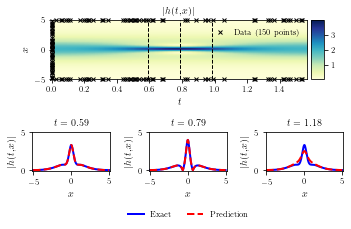

In [24]:
######################################################################
############################# Plotting ###############################
######################################################################    

X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
X_u_train = np.vstack([X0, X_lb, X_ub])

fig, ax = newfig(1.0, 0.9)
ax.axis('off')

####### Row 0: h(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu', 
                extent=[lb[1], ub[1], lb[0], ub[0]], 
                origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[75]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[100]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[125]*np.ones((2,1)), line, 'k--', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
#plt.setp(leg.get_texts(), color='w')
ax.set_title('$|h(t,x)|$', fontsize = 10)

####### Row 1: h(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact_h[:,75], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')    
ax.set_title('$t = %.2f$' % (t[75]), fontsize = 10)
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact_h[:,100], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[100,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])
ax.set_title('$t = %.2f$' % (t[100]), fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact_h[:,125], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[150,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])    
ax.set_title('$t = %.2f$' % (t[150]), fontsize = 10)

    # savefig('./figures/NLS')  

In [25]:
print(1)

1
